In [1]:
import os
import numpy as np
import cupy as cp
import torch
import math
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from PIL import Image

In [3]:
def data_loader(folder_name, row=10, col=10, pixelnum = 950):
  num_data = len(next(os.walk(folder_name))[1])
  data = np.empty([num_data, row * col, pixelnum, pixelnum])
  label = np.empty([num_data, 2, 1, 650, 650])
  for i, folder in enumerate(list(os.walk(folder_name))[1:]):
    label[i, 0] = np.pi*(2*np.array(Image.open(folder[0] + "/phase_result.png").convert('L'))/255 - 1)
    label[i, 1] = np.array(Image.open(folder[0] + "/amp_result.png").convert('L'))/255
    for x in range(row):
      for y in range(col):
        data[i,10*x + y] = np.array(Image.open(folder[0] + "/" + str(x+1) + "_" + str(y+1) + ".PNG"))[700:1650, 560:1510]/255
  return data, label

In [2]:
def single_data_loader(folder_name, row=10, col=10, pixelnum = 950):
  data = np.empty([1, row * col, pixelnum, pixelnum])
  label = np.empty([1, 2, 1, 650, 650])
  label[0,0] = np.pi*(2*np.array(Image.open(folder_name + "/phase_result.png").convert('L'))/255 - 1)
  label[0,1] = np.array(Image.open(folder_name + "/amp_result.png").convert('L'))/255
  for x in range(row):
    for y in range(col):
      data[0,10*x + y] = np.array(Image.open(folder_name + "/" + str(x+1) + "_" + str(y+1) + ".PNG"))[700:1650, 560:1510]/255
  return data, label

In [4]:
def center_crop(imgs, pix_offset, x_start, y_start):
  num_imgs = imgs.shape[1]
  grid_dim = int(np.sqrt(num_imgs))
  if(grid_dim**2 != num_imgs):
    print("Can not produce a grid with",num_imgs,"images")
    return

  num_set = imgs.shape[0]
  x_end = x_start + pix_offset
  y_end = y_start + pix_offset
  grid_img = np.zeros((num_set, grid_dim * grid_dim, pix_offset, pix_offset))
  for i in range(num_set):
    for j, img in enumerate(imgs[i]):
      grid_img[i, j] = img[x_start:x_end ,y_start:y_end]
  return np.einsum('...ikjl', grid_img.reshape(num_set, grid_dim, grid_dim, pix_offset, pix_offset)).reshape(num_set, 1, grid_dim * pix_offset, grid_dim * pix_offset)

In [5]:
# all diffraction images from google drive are stored in a "diffractions" folder 
# (lmk if youre trying to mimic the set up for the code to work)
diffraction_data, label = data_loader("/home/rnakaha2/documents/research/diffractions/")

In [ ]:
np.save('diffraction_data', diffraction_data)
np.save('diffraction_label', label)

<Figure size 432x288 with 0 Axes>

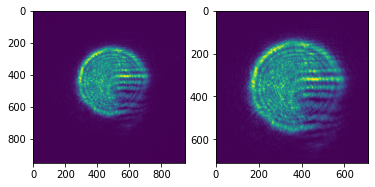

In [6]:
plt.figure()
f, ax = plt.subplots(1,2) 
ax[0].imshow(diffraction_data[0,6], cmap='viridis')
ax[1].imshow(diffraction_data[0,6, 90:800, 120:830])

In [7]:
print(diffraction_data.shape)
diff_grid = center_crop(diffraction_data, 710, 90, 120)
print(diff_grid.shape)

(4, 100, 950, 950)
(4, 1, 7100, 7100)


In [ ]:
np.save('diff_grid_data', diff_grid)

In [3]:
diff_grid = np.load('diff_grid.npy')
label = np.load('diffraction_label.npy')

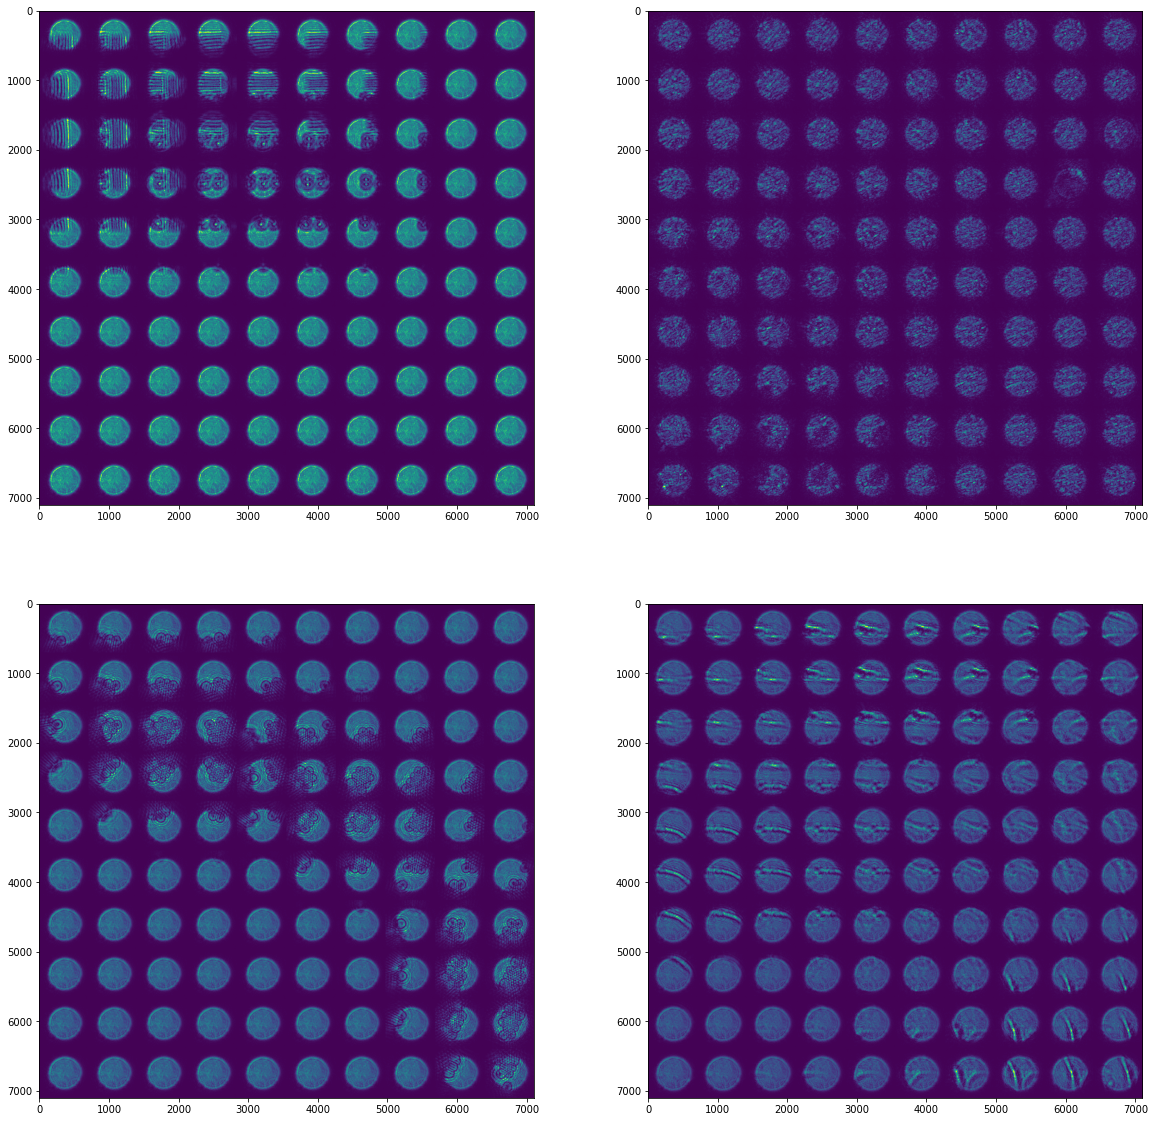

In [4]:
f, ax = plt.subplots(2,2, figsize=(20, 20))
ax[0,0].imshow(diff_grid[0,0])
ax[1,0].imshow(diff_grid[1,0])
ax[0,1].imshow(diff_grid[2,0])
ax[1,1].imshow(diff_grid[3,0])

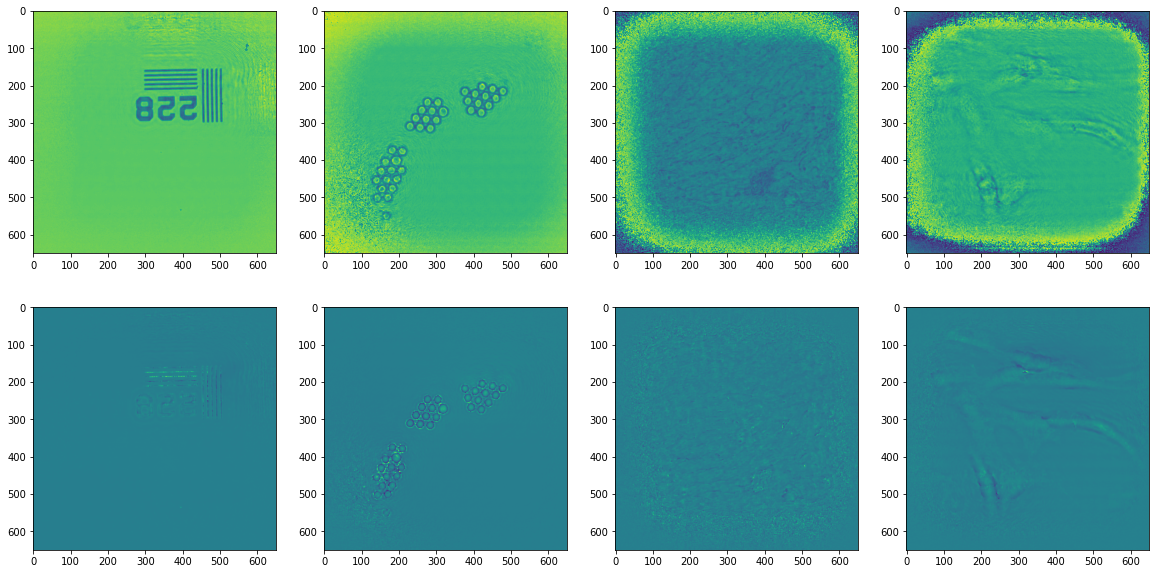

In [5]:
f, ax = plt.subplots(2,4, figsize=(20, 10))
ax[0,0].imshow(label[0,0,0])
ax[1,0].imshow(label[0,1,0])
ax[0,1].imshow(label[1,0,0])
ax[1,1].imshow(label[1,1,0])
ax[0,2].imshow(label[2,0,0])
ax[1,2].imshow(label[2,1,0])
ax[0,3].imshow(label[3,0,0])
ax[1,3].imshow(label[3,1,0])

In [3]:
single_diffraction_data, single_label = single_data_loader("/home/rnakaha2/documents/research/diffractions/20210427_1353_10inch")

In [5]:
single_diff_grid = center_crop(single_diffraction_data, 710, 90, 120)

In [6]:
np.save('dataset/single_data/diff_grid', single_diff_grid)
np.save('dataset/single_data/diffraction_data', single_diffraction_data)
np.save('dataset/single_data/diffraction_label', single_label)

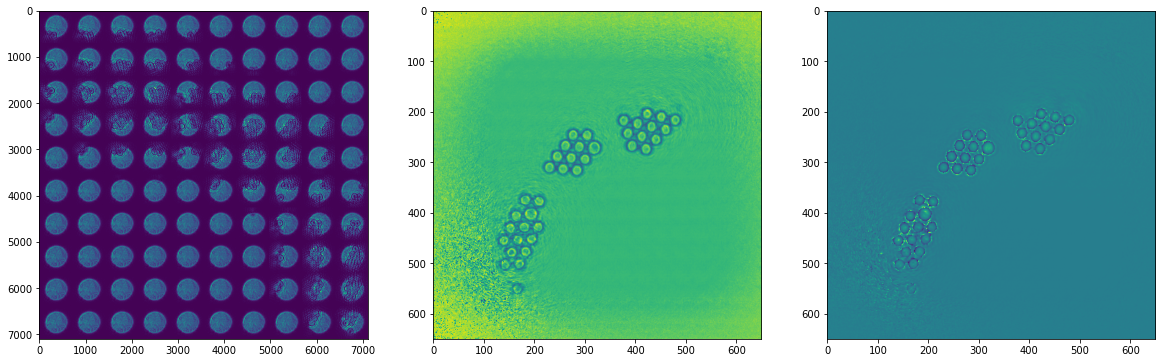

In [9]:
f, ax = plt.subplots(1,3, figsize=(20, 20))
ax[0].imshow(single_diff_grid[0,0])
ax[1].imshow(single_label[0,0,0])
ax[2].imshow(single_label[0,1,0])